In [ ]:
!pip install einops

In [8]:
import torch 
from utils import setup_seed ,  count_parameters  , loading_data ,  ImageDataset
from modeling_mae import MAE_ViT 
from  torch.utils.data import DataLoader 
from tqdm.auto import tqdm 
import time 
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Normalize
import torch.nn.functional as F
from configuration import MAEConfig

config = MAEConfig()

from datasets import load_dataset 
import torchvision

setup_seed(seed=42)

COMPILE = False 
EPOCHS = 100
LR = 5e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EVAL_INTERVAL  = 100

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Define the transform with resizing to 224x224
transform = Compose([
    Resize((32, 32)),  # Resizes images to 224x224
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize with mean and std for 3 channels (RGB)
])

# Load the CIFAR-10 dataset with resizing
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)





Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dataset = ImageDataset(train_data)
val_dataset = ImageDataset(test_data)

In [ ]:
64 * 2

In [ ]:
len(train_dataset)

In [ ]:


train_loader=  DataLoader(
    train_dataset,
    batch_size =128, 
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)



In [11]:
from modeling_mae import MAE_ViT 
from configuration import MAEConfig

config = MAEConfig()


model = MAE_ViT(config=config)
print("Model Parameters:",count_parameters(model))
model.to(DEVICE)

Model Parameters: 7.21M


MAE_ViT(
  (encoder): MAE_Encoder(
    (shuffle): PatchShuffle()
    (patchify): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
    (transformer): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=768, out_features=192, bia

In [12]:
model.load_state_dict(torch.load("/teamspace/studios/this_studio/real_model.pt"))

RuntimeError: Error(s) in loading state_dict for MAE_ViT:
	Missing key(s) in state_dict: "encoder.cls_token", "encoder.pos_embedding", "encoder.patchify.weight", "encoder.patchify.bias", "encoder.transformer.0.norm1.weight", "encoder.transformer.0.norm1.bias", "encoder.transformer.0.attn.qkv.weight", "encoder.transformer.0.attn.proj.weight", "encoder.transformer.0.attn.proj.bias", "encoder.transformer.0.norm2.weight", "encoder.transformer.0.norm2.bias", "encoder.transformer.0.mlp.fc1.weight", "encoder.transformer.0.mlp.fc1.bias", "encoder.transformer.0.mlp.fc2.weight", "encoder.transformer.0.mlp.fc2.bias", "encoder.transformer.1.norm1.weight", "encoder.transformer.1.norm1.bias", "encoder.transformer.1.attn.qkv.weight", "encoder.transformer.1.attn.proj.weight", "encoder.transformer.1.attn.proj.bias", "encoder.transformer.1.norm2.weight", "encoder.transformer.1.norm2.bias", "encoder.transformer.1.mlp.fc1.weight", "encoder.transformer.1.mlp.fc1.bias", "encoder.transformer.1.mlp.fc2.weight", "encoder.transformer.1.mlp.fc2.bias", "encoder.transformer.2.norm1.weight", "encoder.transformer.2.norm1.bias", "encoder.transformer.2.attn.qkv.weight", "encoder.transformer.2.attn.proj.weight", "encoder.transformer.2.attn.proj.bias", "encoder.transformer.2.norm2.weight", "encoder.transformer.2.norm2.bias", "encoder.transformer.2.mlp.fc1.weight", "encoder.transformer.2.mlp.fc1.bias", "encoder.transformer.2.mlp.fc2.weight", "encoder.transformer.2.mlp.fc2.bias", "encoder.transformer.3.norm1.weight", "encoder.transformer.3.norm1.bias", "encoder.transformer.3.attn.qkv.weight", "encoder.transformer.3.attn.proj.weight", "encoder.transformer.3.attn.proj.bias", "encoder.transformer.3.norm2.weight", "encoder.transformer.3.norm2.bias", "encoder.transformer.3.mlp.fc1.weight", "encoder.transformer.3.mlp.fc1.bias", "encoder.transformer.3.mlp.fc2.weight", "encoder.transformer.3.mlp.fc2.bias", "encoder.transformer.4.norm1.weight", "encoder.transformer.4.norm1.bias", "encoder.transformer.4.attn.qkv.weight", "encoder.transformer.4.attn.proj.weight", "encoder.transformer.4.attn.proj.bias", "encoder.transformer.4.norm2.weight", "encoder.transformer.4.norm2.bias", "encoder.transformer.4.mlp.fc1.weight", "encoder.transformer.4.mlp.fc1.bias", "encoder.transformer.4.mlp.fc2.weight", "encoder.transformer.4.mlp.fc2.bias", "encoder.transformer.5.norm1.weight", "encoder.transformer.5.norm1.bias", "encoder.transformer.5.attn.qkv.weight", "encoder.transformer.5.attn.proj.weight", "encoder.transformer.5.attn.proj.bias", "encoder.transformer.5.norm2.weight", "encoder.transformer.5.norm2.bias", "encoder.transformer.5.mlp.fc1.weight", "encoder.transformer.5.mlp.fc1.bias", "encoder.transformer.5.mlp.fc2.weight", "encoder.transformer.5.mlp.fc2.bias", "encoder.transformer.6.norm1.weight", "encoder.transformer.6.norm1.bias", "encoder.transformer.6.attn.qkv.weight", "encoder.transformer.6.attn.proj.weight", "encoder.transformer.6.attn.proj.bias", "encoder.transformer.6.norm2.weight", "encoder.transformer.6.norm2.bias", "encoder.transformer.6.mlp.fc1.weight", "encoder.transformer.6.mlp.fc1.bias", "encoder.transformer.6.mlp.fc2.weight", "encoder.transformer.6.mlp.fc2.bias", "encoder.transformer.7.norm1.weight", "encoder.transformer.7.norm1.bias", "encoder.transformer.7.attn.qkv.weight", "encoder.transformer.7.attn.proj.weight", "encoder.transformer.7.attn.proj.bias", "encoder.transformer.7.norm2.weight", "encoder.transformer.7.norm2.bias", "encoder.transformer.7.mlp.fc1.weight", "encoder.transformer.7.mlp.fc1.bias", "encoder.transformer.7.mlp.fc2.weight", "encoder.transformer.7.mlp.fc2.bias", "encoder.transformer.8.norm1.weight", "encoder.transformer.8.norm1.bias", "encoder.transformer.8.attn.qkv.weight", "encoder.transformer.8.attn.proj.weight", "encoder.transformer.8.attn.proj.bias", "encoder.transformer.8.norm2.weight", "encoder.transformer.8.norm2.bias", "encoder.transformer.8.mlp.fc1.weight", "encoder.transformer.8.mlp.fc1.bias", "encoder.transformer.8.mlp.fc2.weight", "encoder.transformer.8.mlp.fc2.bias", "encoder.transformer.9.norm1.weight", "encoder.transformer.9.norm1.bias", "encoder.transformer.9.attn.qkv.weight", "encoder.transformer.9.attn.proj.weight", "encoder.transformer.9.attn.proj.bias", "encoder.transformer.9.norm2.weight", "encoder.transformer.9.norm2.bias", "encoder.transformer.9.mlp.fc1.weight", "encoder.transformer.9.mlp.fc1.bias", "encoder.transformer.9.mlp.fc2.weight", "encoder.transformer.9.mlp.fc2.bias", "encoder.transformer.10.norm1.weight", "encoder.transformer.10.norm1.bias", "encoder.transformer.10.attn.qkv.weight", "encoder.transformer.10.attn.proj.weight", "encoder.transformer.10.attn.proj.bias", "encoder.transformer.10.norm2.weight", "encoder.transformer.10.norm2.bias", "encoder.transformer.10.mlp.fc1.weight", "encoder.transformer.10.mlp.fc1.bias", "encoder.transformer.10.mlp.fc2.weight", "encoder.transformer.10.mlp.fc2.bias", "encoder.transformer.11.norm1.weight", "encoder.transformer.11.norm1.bias", "encoder.transformer.11.attn.qkv.weight", "encoder.transformer.11.attn.proj.weight", "encoder.transformer.11.attn.proj.bias", "encoder.transformer.11.norm2.weight", "encoder.transformer.11.norm2.bias", "encoder.transformer.11.mlp.fc1.weight", "encoder.transformer.11.mlp.fc1.bias", "encoder.transformer.11.mlp.fc2.weight", "encoder.transformer.11.mlp.fc2.bias", "encoder.layer_norm.weight", "encoder.layer_norm.bias", "decoder.mask_token", "decoder.pos_embedding", "decoder.transformer.0.norm1.weight", "decoder.transformer.0.norm1.bias", "decoder.transformer.0.attn.qkv.weight", "decoder.transformer.0.attn.proj.weight", "decoder.transformer.0.attn.proj.bias", "decoder.transformer.0.norm2.weight", "decoder.transformer.0.norm2.bias", "decoder.transformer.0.mlp.fc1.weight", "decoder.transformer.0.mlp.fc1.bias", "decoder.transformer.0.mlp.fc2.weight", "decoder.transformer.0.mlp.fc2.bias", "decoder.transformer.1.norm1.weight", "decoder.transformer.1.norm1.bias", "decoder.transformer.1.attn.qkv.weight", "decoder.transformer.1.attn.proj.weight", "decoder.transformer.1.attn.proj.bias", "decoder.transformer.1.norm2.weight", "decoder.transformer.1.norm2.bias", "decoder.transformer.1.mlp.fc1.weight", "decoder.transformer.1.mlp.fc1.bias", "decoder.transformer.1.mlp.fc2.weight", "decoder.transformer.1.mlp.fc2.bias", "decoder.transformer.2.norm1.weight", "decoder.transformer.2.norm1.bias", "decoder.transformer.2.attn.qkv.weight", "decoder.transformer.2.attn.proj.weight", "decoder.transformer.2.attn.proj.bias", "decoder.transformer.2.norm2.weight", "decoder.transformer.2.norm2.bias", "decoder.transformer.2.mlp.fc1.weight", "decoder.transformer.2.mlp.fc1.bias", "decoder.transformer.2.mlp.fc2.weight", "decoder.transformer.2.mlp.fc2.bias", "decoder.transformer.3.norm1.weight", "decoder.transformer.3.norm1.bias", "decoder.transformer.3.attn.qkv.weight", "decoder.transformer.3.attn.proj.weight", "decoder.transformer.3.attn.proj.bias", "decoder.transformer.3.norm2.weight", "decoder.transformer.3.norm2.bias", "decoder.transformer.3.mlp.fc1.weight", "decoder.transformer.3.mlp.fc1.bias", "decoder.transformer.3.mlp.fc2.weight", "decoder.transformer.3.mlp.fc2.bias", "decoder.head.weight", "decoder.head.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.encoder.cls_token", "_orig_mod.encoder.pos_embedding", "_orig_mod.encoder.patchify.weight", "_orig_mod.encoder.patchify.bias", "_orig_mod.encoder.transformer.0.norm1.weight", "_orig_mod.encoder.transformer.0.norm1.bias", "_orig_mod.encoder.transformer.0.attn.qkv.weight", "_orig_mod.encoder.transformer.0.attn.proj.weight", "_orig_mod.encoder.transformer.0.attn.proj.bias", "_orig_mod.encoder.transformer.0.norm2.weight", "_orig_mod.encoder.transformer.0.norm2.bias", "_orig_mod.encoder.transformer.0.mlp.fc1.weight", "_orig_mod.encoder.transformer.0.mlp.fc1.bias", "_orig_mod.encoder.transformer.0.mlp.fc2.weight", "_orig_mod.encoder.transformer.0.mlp.fc2.bias", "_orig_mod.encoder.transformer.1.norm1.weight", "_orig_mod.encoder.transformer.1.norm1.bias", "_orig_mod.encoder.transformer.1.attn.qkv.weight", "_orig_mod.encoder.transformer.1.attn.proj.weight", "_orig_mod.encoder.transformer.1.attn.proj.bias", "_orig_mod.encoder.transformer.1.norm2.weight", "_orig_mod.encoder.transformer.1.norm2.bias", "_orig_mod.encoder.transformer.1.mlp.fc1.weight", "_orig_mod.encoder.transformer.1.mlp.fc1.bias", "_orig_mod.encoder.transformer.1.mlp.fc2.weight", "_orig_mod.encoder.transformer.1.mlp.fc2.bias", "_orig_mod.encoder.transformer.2.norm1.weight", "_orig_mod.encoder.transformer.2.norm1.bias", "_orig_mod.encoder.transformer.2.attn.qkv.weight", "_orig_mod.encoder.transformer.2.attn.proj.weight", "_orig_mod.encoder.transformer.2.attn.proj.bias", "_orig_mod.encoder.transformer.2.norm2.weight", "_orig_mod.encoder.transformer.2.norm2.bias", "_orig_mod.encoder.transformer.2.mlp.fc1.weight", "_orig_mod.encoder.transformer.2.mlp.fc1.bias", "_orig_mod.encoder.transformer.2.mlp.fc2.weight", "_orig_mod.encoder.transformer.2.mlp.fc2.bias", "_orig_mod.encoder.transformer.3.norm1.weight", "_orig_mod.encoder.transformer.3.norm1.bias", "_orig_mod.encoder.transformer.3.attn.qkv.weight", "_orig_mod.encoder.transformer.3.attn.proj.weight", "_orig_mod.encoder.transformer.3.attn.proj.bias", "_orig_mod.encoder.transformer.3.norm2.weight", "_orig_mod.encoder.transformer.3.norm2.bias", "_orig_mod.encoder.transformer.3.mlp.fc1.weight", "_orig_mod.encoder.transformer.3.mlp.fc1.bias", "_orig_mod.encoder.transformer.3.mlp.fc2.weight", "_orig_mod.encoder.transformer.3.mlp.fc2.bias", "_orig_mod.encoder.transformer.4.norm1.weight", "_orig_mod.encoder.transformer.4.norm1.bias", "_orig_mod.encoder.transformer.4.attn.qkv.weight", "_orig_mod.encoder.transformer.4.attn.proj.weight", "_orig_mod.encoder.transformer.4.attn.proj.bias", "_orig_mod.encoder.transformer.4.norm2.weight", "_orig_mod.encoder.transformer.4.norm2.bias", "_orig_mod.encoder.transformer.4.mlp.fc1.weight", "_orig_mod.encoder.transformer.4.mlp.fc1.bias", "_orig_mod.encoder.transformer.4.mlp.fc2.weight", "_orig_mod.encoder.transformer.4.mlp.fc2.bias", "_orig_mod.encoder.transformer.5.norm1.weight", "_orig_mod.encoder.transformer.5.norm1.bias", "_orig_mod.encoder.transformer.5.attn.qkv.weight", "_orig_mod.encoder.transformer.5.attn.proj.weight", "_orig_mod.encoder.transformer.5.attn.proj.bias", "_orig_mod.encoder.transformer.5.norm2.weight", "_orig_mod.encoder.transformer.5.norm2.bias", "_orig_mod.encoder.transformer.5.mlp.fc1.weight", "_orig_mod.encoder.transformer.5.mlp.fc1.bias", "_orig_mod.encoder.transformer.5.mlp.fc2.weight", "_orig_mod.encoder.transformer.5.mlp.fc2.bias", "_orig_mod.encoder.transformer.6.norm1.weight", "_orig_mod.encoder.transformer.6.norm1.bias", "_orig_mod.encoder.transformer.6.attn.qkv.weight", "_orig_mod.encoder.transformer.6.attn.proj.weight", "_orig_mod.encoder.transformer.6.attn.proj.bias", "_orig_mod.encoder.transformer.6.norm2.weight", "_orig_mod.encoder.transformer.6.norm2.bias", "_orig_mod.encoder.transformer.6.mlp.fc1.weight", "_orig_mod.encoder.transformer.6.mlp.fc1.bias", "_orig_mod.encoder.transformer.6.mlp.fc2.weight", "_orig_mod.encoder.transformer.6.mlp.fc2.bias", "_orig_mod.encoder.transformer.7.norm1.weight", "_orig_mod.encoder.transformer.7.norm1.bias", "_orig_mod.encoder.transformer.7.attn.qkv.weight", "_orig_mod.encoder.transformer.7.attn.proj.weight", "_orig_mod.encoder.transformer.7.attn.proj.bias", "_orig_mod.encoder.transformer.7.norm2.weight", "_orig_mod.encoder.transformer.7.norm2.bias", "_orig_mod.encoder.transformer.7.mlp.fc1.weight", "_orig_mod.encoder.transformer.7.mlp.fc1.bias", "_orig_mod.encoder.transformer.7.mlp.fc2.weight", "_orig_mod.encoder.transformer.7.mlp.fc2.bias", "_orig_mod.encoder.transformer.8.norm1.weight", "_orig_mod.encoder.transformer.8.norm1.bias", "_orig_mod.encoder.transformer.8.attn.qkv.weight", "_orig_mod.encoder.transformer.8.attn.proj.weight", "_orig_mod.encoder.transformer.8.attn.proj.bias", "_orig_mod.encoder.transformer.8.norm2.weight", "_orig_mod.encoder.transformer.8.norm2.bias", "_orig_mod.encoder.transformer.8.mlp.fc1.weight", "_orig_mod.encoder.transformer.8.mlp.fc1.bias", "_orig_mod.encoder.transformer.8.mlp.fc2.weight", "_orig_mod.encoder.transformer.8.mlp.fc2.bias", "_orig_mod.encoder.transformer.9.norm1.weight", "_orig_mod.encoder.transformer.9.norm1.bias", "_orig_mod.encoder.transformer.9.attn.qkv.weight", "_orig_mod.encoder.transformer.9.attn.proj.weight", "_orig_mod.encoder.transformer.9.attn.proj.bias", "_orig_mod.encoder.transformer.9.norm2.weight", "_orig_mod.encoder.transformer.9.norm2.bias", "_orig_mod.encoder.transformer.9.mlp.fc1.weight", "_orig_mod.encoder.transformer.9.mlp.fc1.bias", "_orig_mod.encoder.transformer.9.mlp.fc2.weight", "_orig_mod.encoder.transformer.9.mlp.fc2.bias", "_orig_mod.encoder.transformer.10.norm1.weight", "_orig_mod.encoder.transformer.10.norm1.bias", "_orig_mod.encoder.transformer.10.attn.qkv.weight", "_orig_mod.encoder.transformer.10.attn.proj.weight", "_orig_mod.encoder.transformer.10.attn.proj.bias", "_orig_mod.encoder.transformer.10.norm2.weight", "_orig_mod.encoder.transformer.10.norm2.bias", "_orig_mod.encoder.transformer.10.mlp.fc1.weight", "_orig_mod.encoder.transformer.10.mlp.fc1.bias", "_orig_mod.encoder.transformer.10.mlp.fc2.weight", "_orig_mod.encoder.transformer.10.mlp.fc2.bias", "_orig_mod.encoder.transformer.11.norm1.weight", "_orig_mod.encoder.transformer.11.norm1.bias", "_orig_mod.encoder.transformer.11.attn.qkv.weight", "_orig_mod.encoder.transformer.11.attn.proj.weight", "_orig_mod.encoder.transformer.11.attn.proj.bias", "_orig_mod.encoder.transformer.11.norm2.weight", "_orig_mod.encoder.transformer.11.norm2.bias", "_orig_mod.encoder.transformer.11.mlp.fc1.weight", "_orig_mod.encoder.transformer.11.mlp.fc1.bias", "_orig_mod.encoder.transformer.11.mlp.fc2.weight", "_orig_mod.encoder.transformer.11.mlp.fc2.bias", "_orig_mod.encoder.layer_norm.weight", "_orig_mod.encoder.layer_norm.bias", "_orig_mod.decoder.mask_token", "_orig_mod.decoder.pos_embedding", "_orig_mod.decoder.transformer.0.norm1.weight", "_orig_mod.decoder.transformer.0.norm1.bias", "_orig_mod.decoder.transformer.0.attn.qkv.weight", "_orig_mod.decoder.transformer.0.attn.proj.weight", "_orig_mod.decoder.transformer.0.attn.proj.bias", "_orig_mod.decoder.transformer.0.norm2.weight", "_orig_mod.decoder.transformer.0.norm2.bias", "_orig_mod.decoder.transformer.0.mlp.fc1.weight", "_orig_mod.decoder.transformer.0.mlp.fc1.bias", "_orig_mod.decoder.transformer.0.mlp.fc2.weight", "_orig_mod.decoder.transformer.0.mlp.fc2.bias", "_orig_mod.decoder.transformer.1.norm1.weight", "_orig_mod.decoder.transformer.1.norm1.bias", "_orig_mod.decoder.transformer.1.attn.qkv.weight", "_orig_mod.decoder.transformer.1.attn.proj.weight", "_orig_mod.decoder.transformer.1.attn.proj.bias", "_orig_mod.decoder.transformer.1.norm2.weight", "_orig_mod.decoder.transformer.1.norm2.bias", "_orig_mod.decoder.transformer.1.mlp.fc1.weight", "_orig_mod.decoder.transformer.1.mlp.fc1.bias", "_orig_mod.decoder.transformer.1.mlp.fc2.weight", "_orig_mod.decoder.transformer.1.mlp.fc2.bias", "_orig_mod.decoder.transformer.2.norm1.weight", "_orig_mod.decoder.transformer.2.norm1.bias", "_orig_mod.decoder.transformer.2.attn.qkv.weight", "_orig_mod.decoder.transformer.2.attn.proj.weight", "_orig_mod.decoder.transformer.2.attn.proj.bias", "_orig_mod.decoder.transformer.2.norm2.weight", "_orig_mod.decoder.transformer.2.norm2.bias", "_orig_mod.decoder.transformer.2.mlp.fc1.weight", "_orig_mod.decoder.transformer.2.mlp.fc1.bias", "_orig_mod.decoder.transformer.2.mlp.fc2.weight", "_orig_mod.decoder.transformer.2.mlp.fc2.bias", "_orig_mod.decoder.transformer.3.norm1.weight", "_orig_mod.decoder.transformer.3.norm1.bias", "_orig_mod.decoder.transformer.3.attn.qkv.weight", "_orig_mod.decoder.transformer.3.attn.proj.weight", "_orig_mod.decoder.transformer.3.attn.proj.bias", "_orig_mod.decoder.transformer.3.norm2.weight", "_orig_mod.decoder.transformer.3.norm2.bias", "_orig_mod.decoder.transformer.3.mlp.fc1.weight", "_orig_mod.decoder.transformer.3.mlp.fc1.bias", "_orig_mod.decoder.transformer.3.mlp.fc2.weight", "_orig_mod.decoder.transformer.3.mlp.fc2.bias", "_orig_mod.decoder.head.weight", "_orig_mod.decoder.head.bias". 

In [ ]:
criterion = torch.nn.MSELoss()


In [ ]:
def patchify(imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

def unpatchify(x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

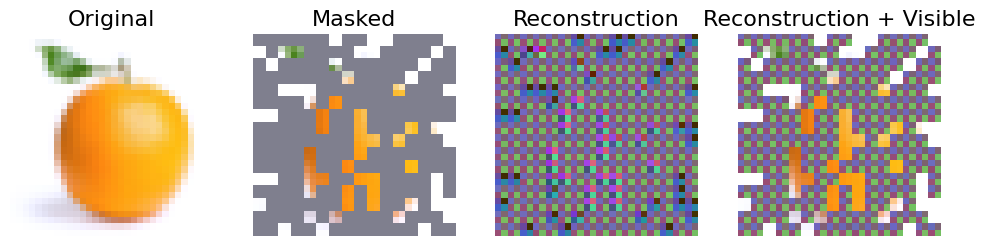

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

imagenet_mean = np.array([0.5, 0.5, 0.56])
imagenet_std = np.array([0.5, 0.5, 0.5])

def show_image(image, title='', mean=imagenet_mean, std=imagenet_std):
    """
    Displays an image after denormalizing and clipping the values.
    
    Args:
        image (Tensor): Image tensor in NHWC format.
        title (str): Title of the image.
        mean (np.array): Mean used for normalization.
        std (np.array): Standard deviation used for normalization.
    """
    # image is expected to be [H, W, 3] after permuting
    assert image.shape[2] == 3
    image = torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_inference(image, model, input_size=(32, 32), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Runs inference using the given model and displays various stages of the image.

    Args:
        image (PIL.Image): Input image.
        model (torch.nn.Module): Pre-trained model.
        input_size (tuple): Size to resize the image to.
        mean (tuple): Mean for normalization.
        std (tuple): Standard deviation for normalization.
    """
    # Preprocessing: resize, to tensor, normalize
    transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize to the model's input size
        transforms.ToTensor(),  # Convert image to Tensor
        transforms.Normalize(mean=mean, std=std)  # Normalize using given mean and std
    ])

    model.eval()  # Ensure the model is in evaluation mode
    image = image.convert('RGB')  # Ensure the image is in RGB format
    image_tensor = transform(image).unsqueeze(0)  # Transform and add batch dimension

    model.to("cpu")
    image_tensor = image_tensor.to("cpu")  # Move image to CPU if necessary

    # No gradient needed during inference
    with torch.no_grad():
        # Forward pass through the model
        out, mask = model(image_tensor)

        # Move outputs to CPU and detach
        y = out.detach().cpu()
        mask = mask.detach().cpu()

        # Convert tensors from NCHW to NHWC format for visualization
        x = image_tensor.permute(0, 2, 3, 1).cpu()  # Original input image
        y = y.permute(0, 2, 3, 1)  # Reconstructed output
        mask = mask.permute(0, 2, 3, 1)  # Mask output

        # Generate masked image (original image with mask applied)
        im_masked = x * (1 - mask)

        # Combine masked and reconstructed patches for the final output
        im_paste = im_masked + y * mask

        # Display results in a 1x4 grid
        plt.rcParams['figure.figsize'] = [12, 12]

        plt.subplot(1, 4, 1)
        show_image(x[0], "Original", mean, std)

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "Masked", mean, std)

        plt.subplot(1, 4, 3)
        show_image(y[0], "Reconstruction", mean, std)

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "Reconstruction + Visible", mean, std)

        plt.show()


# Example usage
image_path = '/teamspace/studios/this_studio/orange.jpg'
image = Image.open(image_path)
# Ensure you have the correct model initialized
# model = MAE_ViT(...)  # Use your actual model initialization here
run_inference(image, model)

In [ ]:
model.to(DEVICE)

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import time

# Hyperparameters
EPOCHS = 120
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHT_DECAY= 1e-4


# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
lr_func = lambda epoch: min((epoch + 1) / (10 + 1e-8), 0.5 * (math.cos(epoch / EPOCHS * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)

print("Starting to train")


# Initialize lists to store metrics
train_losses = []
val_losses = []
learning_rates = []
step_times = []
grad_norms = []

model = torch.compile(model)
torch.set_float32_matmul_precision('high')

def calculate_loss(preds , image , mask,mask_ratio):
    return torch.mean((preds - image) ** 2 * mask) / mask_ratio

for epoch in range(EPOCHS):
    model.train()
    epoch_train_losses = []
    step_times = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for step, (image, _) in progress_bar:
        start_time = time.time()
        
        model.to(DEVICE)

        image = image.to(DEVICE)
        optimizer.zero_grad()

        out, mask = model(image)
        loss = calculate_loss(preds=out, image=image, mask=mask, mask_ratio=0.75)

        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        step_times.append((time.time() - start_time) * 1000)  # Step time in milliseconds
        
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'step_time': f"{(time.time() - start_time) * 1000:.4F}ms",
            'lr': f"{lr_scheduler.get_last_lr()[0]:.6f}"
        })

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()  # Set the model to evaluation mode
    epoch_val_losses = []

    with torch.no_grad():  # Disable gradient tracking
        val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Validation {epoch+1}/{EPOCHS}")
        
        for val_step, (val_image, _) in val_progress_bar:
            val_image = val_image.to(DEVICE)
            
            out, mask = model(val_image)
            val_loss = calculate_loss(preds=out, image=val_image, mask=mask, mask_ratio=0.75)
            epoch_val_losses.append(val_loss.item())

        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS} - Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}")

    lr_scheduler.step()





In [ ]:
torch.save(model.state_dict(), "real_model.pt")




In [ ]:

image_path = '/teamspace/studios/this_studio/orange.jpg'
img = Image.open(image_path)
run_inference(img, model)

In [ ]:
train_losses

In [ ]:
val_losses[:4]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Validation Loss')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.title('Validation Losses Over Training')
plt.legend()
plt.grid(True)
plt.show()

print("Training complete")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.title('Validation Losses Over Training')
plt.legend()
plt.grid(True)
plt.show()

print("Training complete")


In [ ]:
import torch

# Define paths
model_path = 'new_model_2.pth'
optimizer_path = 'optimizer.pth'
scheduler_path = 'scheduler.pth'

# Save model, optimizer, and scheduler
def save_checkpoint(model, optimizer, scheduler, model_path, optimizer_path, scheduler_path):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, model_path)

# Example usage
save_checkpoint(model, optimizer, scheduler, model_path, optimizer_path, scheduler_path)


In [6]:
import torch

# Define paths
model_path = '/teamspace/studios/this_studio/real_model.pt'

# Load model, optimizer, and scheduler
def load_checkpoint(model,model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

model  = load_checkpoint(model,model_path)
model.eval()
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[6], line 13
      9     model.load_state_dict(checkpoint['model_state_dict'])
     11     return model
---> 13 model  = load_checkpoint(model,model_path)
     14 model.eval()

Cell In[6], line 9
      7 def load_checkpoint(model,model_path):
      8     checkpoint = torch.load(model_path)
----> 9     model.load_state_dict(checkpoint['model_state_dict'])
     11     return model

KeyError: 'model_state_dict'

KeyError: 'model_state_dict'

In [10]:
model.load_state_dict(torch.load("/teamspace/studios/this_studio/real_model.pt"))

RuntimeError: Error(s) in loading state_dict for MAE_ViT:
	Missing key(s) in state_dict: "encoder.cls_token", "encoder.pos_embedding", "encoder.patchify.weight", "encoder.patchify.bias", "encoder.transformer.0.norm1.weight", "encoder.transformer.0.norm1.bias", "encoder.transformer.0.attn.qkv.weight", "encoder.transformer.0.attn.proj.weight", "encoder.transformer.0.attn.proj.bias", "encoder.transformer.0.norm2.weight", "encoder.transformer.0.norm2.bias", "encoder.transformer.0.mlp.fc1.weight", "encoder.transformer.0.mlp.fc1.bias", "encoder.transformer.0.mlp.fc2.weight", "encoder.transformer.0.mlp.fc2.bias", "encoder.transformer.1.norm1.weight", "encoder.transformer.1.norm1.bias", "encoder.transformer.1.attn.qkv.weight", "encoder.transformer.1.attn.proj.weight", "encoder.transformer.1.attn.proj.bias", "encoder.transformer.1.norm2.weight", "encoder.transformer.1.norm2.bias", "encoder.transformer.1.mlp.fc1.weight", "encoder.transformer.1.mlp.fc1.bias", "encoder.transformer.1.mlp.fc2.weight", "encoder.transformer.1.mlp.fc2.bias", "encoder.transformer.2.norm1.weight", "encoder.transformer.2.norm1.bias", "encoder.transformer.2.attn.qkv.weight", "encoder.transformer.2.attn.proj.weight", "encoder.transformer.2.attn.proj.bias", "encoder.transformer.2.norm2.weight", "encoder.transformer.2.norm2.bias", "encoder.transformer.2.mlp.fc1.weight", "encoder.transformer.2.mlp.fc1.bias", "encoder.transformer.2.mlp.fc2.weight", "encoder.transformer.2.mlp.fc2.bias", "encoder.transformer.3.norm1.weight", "encoder.transformer.3.norm1.bias", "encoder.transformer.3.attn.qkv.weight", "encoder.transformer.3.attn.proj.weight", "encoder.transformer.3.attn.proj.bias", "encoder.transformer.3.norm2.weight", "encoder.transformer.3.norm2.bias", "encoder.transformer.3.mlp.fc1.weight", "encoder.transformer.3.mlp.fc1.bias", "encoder.transformer.3.mlp.fc2.weight", "encoder.transformer.3.mlp.fc2.bias", "encoder.transformer.4.norm1.weight", "encoder.transformer.4.norm1.bias", "encoder.transformer.4.attn.qkv.weight", "encoder.transformer.4.attn.proj.weight", "encoder.transformer.4.attn.proj.bias", "encoder.transformer.4.norm2.weight", "encoder.transformer.4.norm2.bias", "encoder.transformer.4.mlp.fc1.weight", "encoder.transformer.4.mlp.fc1.bias", "encoder.transformer.4.mlp.fc2.weight", "encoder.transformer.4.mlp.fc2.bias", "encoder.transformer.5.norm1.weight", "encoder.transformer.5.norm1.bias", "encoder.transformer.5.attn.qkv.weight", "encoder.transformer.5.attn.proj.weight", "encoder.transformer.5.attn.proj.bias", "encoder.transformer.5.norm2.weight", "encoder.transformer.5.norm2.bias", "encoder.transformer.5.mlp.fc1.weight", "encoder.transformer.5.mlp.fc1.bias", "encoder.transformer.5.mlp.fc2.weight", "encoder.transformer.5.mlp.fc2.bias", "encoder.transformer.6.norm1.weight", "encoder.transformer.6.norm1.bias", "encoder.transformer.6.attn.qkv.weight", "encoder.transformer.6.attn.proj.weight", "encoder.transformer.6.attn.proj.bias", "encoder.transformer.6.norm2.weight", "encoder.transformer.6.norm2.bias", "encoder.transformer.6.mlp.fc1.weight", "encoder.transformer.6.mlp.fc1.bias", "encoder.transformer.6.mlp.fc2.weight", "encoder.transformer.6.mlp.fc2.bias", "encoder.transformer.7.norm1.weight", "encoder.transformer.7.norm1.bias", "encoder.transformer.7.attn.qkv.weight", "encoder.transformer.7.attn.proj.weight", "encoder.transformer.7.attn.proj.bias", "encoder.transformer.7.norm2.weight", "encoder.transformer.7.norm2.bias", "encoder.transformer.7.mlp.fc1.weight", "encoder.transformer.7.mlp.fc1.bias", "encoder.transformer.7.mlp.fc2.weight", "encoder.transformer.7.mlp.fc2.bias", "encoder.transformer.8.norm1.weight", "encoder.transformer.8.norm1.bias", "encoder.transformer.8.attn.qkv.weight", "encoder.transformer.8.attn.proj.weight", "encoder.transformer.8.attn.proj.bias", "encoder.transformer.8.norm2.weight", "encoder.transformer.8.norm2.bias", "encoder.transformer.8.mlp.fc1.weight", "encoder.transformer.8.mlp.fc1.bias", "encoder.transformer.8.mlp.fc2.weight", "encoder.transformer.8.mlp.fc2.bias", "encoder.transformer.9.norm1.weight", "encoder.transformer.9.norm1.bias", "encoder.transformer.9.attn.qkv.weight", "encoder.transformer.9.attn.proj.weight", "encoder.transformer.9.attn.proj.bias", "encoder.transformer.9.norm2.weight", "encoder.transformer.9.norm2.bias", "encoder.transformer.9.mlp.fc1.weight", "encoder.transformer.9.mlp.fc1.bias", "encoder.transformer.9.mlp.fc2.weight", "encoder.transformer.9.mlp.fc2.bias", "encoder.transformer.10.norm1.weight", "encoder.transformer.10.norm1.bias", "encoder.transformer.10.attn.qkv.weight", "encoder.transformer.10.attn.proj.weight", "encoder.transformer.10.attn.proj.bias", "encoder.transformer.10.norm2.weight", "encoder.transformer.10.norm2.bias", "encoder.transformer.10.mlp.fc1.weight", "encoder.transformer.10.mlp.fc1.bias", "encoder.transformer.10.mlp.fc2.weight", "encoder.transformer.10.mlp.fc2.bias", "encoder.transformer.11.norm1.weight", "encoder.transformer.11.norm1.bias", "encoder.transformer.11.attn.qkv.weight", "encoder.transformer.11.attn.proj.weight", "encoder.transformer.11.attn.proj.bias", "encoder.transformer.11.norm2.weight", "encoder.transformer.11.norm2.bias", "encoder.transformer.11.mlp.fc1.weight", "encoder.transformer.11.mlp.fc1.bias", "encoder.transformer.11.mlp.fc2.weight", "encoder.transformer.11.mlp.fc2.bias", "encoder.layer_norm.weight", "encoder.layer_norm.bias", "decoder.mask_token", "decoder.pos_embedding", "decoder.transformer.0.norm1.weight", "decoder.transformer.0.norm1.bias", "decoder.transformer.0.attn.qkv.weight", "decoder.transformer.0.attn.proj.weight", "decoder.transformer.0.attn.proj.bias", "decoder.transformer.0.norm2.weight", "decoder.transformer.0.norm2.bias", "decoder.transformer.0.mlp.fc1.weight", "decoder.transformer.0.mlp.fc1.bias", "decoder.transformer.0.mlp.fc2.weight", "decoder.transformer.0.mlp.fc2.bias", "decoder.transformer.1.norm1.weight", "decoder.transformer.1.norm1.bias", "decoder.transformer.1.attn.qkv.weight", "decoder.transformer.1.attn.proj.weight", "decoder.transformer.1.attn.proj.bias", "decoder.transformer.1.norm2.weight", "decoder.transformer.1.norm2.bias", "decoder.transformer.1.mlp.fc1.weight", "decoder.transformer.1.mlp.fc1.bias", "decoder.transformer.1.mlp.fc2.weight", "decoder.transformer.1.mlp.fc2.bias", "decoder.transformer.2.norm1.weight", "decoder.transformer.2.norm1.bias", "decoder.transformer.2.attn.qkv.weight", "decoder.transformer.2.attn.proj.weight", "decoder.transformer.2.attn.proj.bias", "decoder.transformer.2.norm2.weight", "decoder.transformer.2.norm2.bias", "decoder.transformer.2.mlp.fc1.weight", "decoder.transformer.2.mlp.fc1.bias", "decoder.transformer.2.mlp.fc2.weight", "decoder.transformer.2.mlp.fc2.bias", "decoder.transformer.3.norm1.weight", "decoder.transformer.3.norm1.bias", "decoder.transformer.3.attn.qkv.weight", "decoder.transformer.3.attn.proj.weight", "decoder.transformer.3.attn.proj.bias", "decoder.transformer.3.norm2.weight", "decoder.transformer.3.norm2.bias", "decoder.transformer.3.mlp.fc1.weight", "decoder.transformer.3.mlp.fc1.bias", "decoder.transformer.3.mlp.fc2.weight", "decoder.transformer.3.mlp.fc2.bias", "decoder.head.weight", "decoder.head.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.encoder.cls_token", "_orig_mod.encoder.pos_embedding", "_orig_mod.encoder.patchify.weight", "_orig_mod.encoder.patchify.bias", "_orig_mod.encoder.transformer.0.norm1.weight", "_orig_mod.encoder.transformer.0.norm1.bias", "_orig_mod.encoder.transformer.0.attn.qkv.weight", "_orig_mod.encoder.transformer.0.attn.proj.weight", "_orig_mod.encoder.transformer.0.attn.proj.bias", "_orig_mod.encoder.transformer.0.norm2.weight", "_orig_mod.encoder.transformer.0.norm2.bias", "_orig_mod.encoder.transformer.0.mlp.fc1.weight", "_orig_mod.encoder.transformer.0.mlp.fc1.bias", "_orig_mod.encoder.transformer.0.mlp.fc2.weight", "_orig_mod.encoder.transformer.0.mlp.fc2.bias", "_orig_mod.encoder.transformer.1.norm1.weight", "_orig_mod.encoder.transformer.1.norm1.bias", "_orig_mod.encoder.transformer.1.attn.qkv.weight", "_orig_mod.encoder.transformer.1.attn.proj.weight", "_orig_mod.encoder.transformer.1.attn.proj.bias", "_orig_mod.encoder.transformer.1.norm2.weight", "_orig_mod.encoder.transformer.1.norm2.bias", "_orig_mod.encoder.transformer.1.mlp.fc1.weight", "_orig_mod.encoder.transformer.1.mlp.fc1.bias", "_orig_mod.encoder.transformer.1.mlp.fc2.weight", "_orig_mod.encoder.transformer.1.mlp.fc2.bias", "_orig_mod.encoder.transformer.2.norm1.weight", "_orig_mod.encoder.transformer.2.norm1.bias", "_orig_mod.encoder.transformer.2.attn.qkv.weight", "_orig_mod.encoder.transformer.2.attn.proj.weight", "_orig_mod.encoder.transformer.2.attn.proj.bias", "_orig_mod.encoder.transformer.2.norm2.weight", "_orig_mod.encoder.transformer.2.norm2.bias", "_orig_mod.encoder.transformer.2.mlp.fc1.weight", "_orig_mod.encoder.transformer.2.mlp.fc1.bias", "_orig_mod.encoder.transformer.2.mlp.fc2.weight", "_orig_mod.encoder.transformer.2.mlp.fc2.bias", "_orig_mod.encoder.transformer.3.norm1.weight", "_orig_mod.encoder.transformer.3.norm1.bias", "_orig_mod.encoder.transformer.3.attn.qkv.weight", "_orig_mod.encoder.transformer.3.attn.proj.weight", "_orig_mod.encoder.transformer.3.attn.proj.bias", "_orig_mod.encoder.transformer.3.norm2.weight", "_orig_mod.encoder.transformer.3.norm2.bias", "_orig_mod.encoder.transformer.3.mlp.fc1.weight", "_orig_mod.encoder.transformer.3.mlp.fc1.bias", "_orig_mod.encoder.transformer.3.mlp.fc2.weight", "_orig_mod.encoder.transformer.3.mlp.fc2.bias", "_orig_mod.encoder.transformer.4.norm1.weight", "_orig_mod.encoder.transformer.4.norm1.bias", "_orig_mod.encoder.transformer.4.attn.qkv.weight", "_orig_mod.encoder.transformer.4.attn.proj.weight", "_orig_mod.encoder.transformer.4.attn.proj.bias", "_orig_mod.encoder.transformer.4.norm2.weight", "_orig_mod.encoder.transformer.4.norm2.bias", "_orig_mod.encoder.transformer.4.mlp.fc1.weight", "_orig_mod.encoder.transformer.4.mlp.fc1.bias", "_orig_mod.encoder.transformer.4.mlp.fc2.weight", "_orig_mod.encoder.transformer.4.mlp.fc2.bias", "_orig_mod.encoder.transformer.5.norm1.weight", "_orig_mod.encoder.transformer.5.norm1.bias", "_orig_mod.encoder.transformer.5.attn.qkv.weight", "_orig_mod.encoder.transformer.5.attn.proj.weight", "_orig_mod.encoder.transformer.5.attn.proj.bias", "_orig_mod.encoder.transformer.5.norm2.weight", "_orig_mod.encoder.transformer.5.norm2.bias", "_orig_mod.encoder.transformer.5.mlp.fc1.weight", "_orig_mod.encoder.transformer.5.mlp.fc1.bias", "_orig_mod.encoder.transformer.5.mlp.fc2.weight", "_orig_mod.encoder.transformer.5.mlp.fc2.bias", "_orig_mod.encoder.transformer.6.norm1.weight", "_orig_mod.encoder.transformer.6.norm1.bias", "_orig_mod.encoder.transformer.6.attn.qkv.weight", "_orig_mod.encoder.transformer.6.attn.proj.weight", "_orig_mod.encoder.transformer.6.attn.proj.bias", "_orig_mod.encoder.transformer.6.norm2.weight", "_orig_mod.encoder.transformer.6.norm2.bias", "_orig_mod.encoder.transformer.6.mlp.fc1.weight", "_orig_mod.encoder.transformer.6.mlp.fc1.bias", "_orig_mod.encoder.transformer.6.mlp.fc2.weight", "_orig_mod.encoder.transformer.6.mlp.fc2.bias", "_orig_mod.encoder.transformer.7.norm1.weight", "_orig_mod.encoder.transformer.7.norm1.bias", "_orig_mod.encoder.transformer.7.attn.qkv.weight", "_orig_mod.encoder.transformer.7.attn.proj.weight", "_orig_mod.encoder.transformer.7.attn.proj.bias", "_orig_mod.encoder.transformer.7.norm2.weight", "_orig_mod.encoder.transformer.7.norm2.bias", "_orig_mod.encoder.transformer.7.mlp.fc1.weight", "_orig_mod.encoder.transformer.7.mlp.fc1.bias", "_orig_mod.encoder.transformer.7.mlp.fc2.weight", "_orig_mod.encoder.transformer.7.mlp.fc2.bias", "_orig_mod.encoder.transformer.8.norm1.weight", "_orig_mod.encoder.transformer.8.norm1.bias", "_orig_mod.encoder.transformer.8.attn.qkv.weight", "_orig_mod.encoder.transformer.8.attn.proj.weight", "_orig_mod.encoder.transformer.8.attn.proj.bias", "_orig_mod.encoder.transformer.8.norm2.weight", "_orig_mod.encoder.transformer.8.norm2.bias", "_orig_mod.encoder.transformer.8.mlp.fc1.weight", "_orig_mod.encoder.transformer.8.mlp.fc1.bias", "_orig_mod.encoder.transformer.8.mlp.fc2.weight", "_orig_mod.encoder.transformer.8.mlp.fc2.bias", "_orig_mod.encoder.transformer.9.norm1.weight", "_orig_mod.encoder.transformer.9.norm1.bias", "_orig_mod.encoder.transformer.9.attn.qkv.weight", "_orig_mod.encoder.transformer.9.attn.proj.weight", "_orig_mod.encoder.transformer.9.attn.proj.bias", "_orig_mod.encoder.transformer.9.norm2.weight", "_orig_mod.encoder.transformer.9.norm2.bias", "_orig_mod.encoder.transformer.9.mlp.fc1.weight", "_orig_mod.encoder.transformer.9.mlp.fc1.bias", "_orig_mod.encoder.transformer.9.mlp.fc2.weight", "_orig_mod.encoder.transformer.9.mlp.fc2.bias", "_orig_mod.encoder.transformer.10.norm1.weight", "_orig_mod.encoder.transformer.10.norm1.bias", "_orig_mod.encoder.transformer.10.attn.qkv.weight", "_orig_mod.encoder.transformer.10.attn.proj.weight", "_orig_mod.encoder.transformer.10.attn.proj.bias", "_orig_mod.encoder.transformer.10.norm2.weight", "_orig_mod.encoder.transformer.10.norm2.bias", "_orig_mod.encoder.transformer.10.mlp.fc1.weight", "_orig_mod.encoder.transformer.10.mlp.fc1.bias", "_orig_mod.encoder.transformer.10.mlp.fc2.weight", "_orig_mod.encoder.transformer.10.mlp.fc2.bias", "_orig_mod.encoder.transformer.11.norm1.weight", "_orig_mod.encoder.transformer.11.norm1.bias", "_orig_mod.encoder.transformer.11.attn.qkv.weight", "_orig_mod.encoder.transformer.11.attn.proj.weight", "_orig_mod.encoder.transformer.11.attn.proj.bias", "_orig_mod.encoder.transformer.11.norm2.weight", "_orig_mod.encoder.transformer.11.norm2.bias", "_orig_mod.encoder.transformer.11.mlp.fc1.weight", "_orig_mod.encoder.transformer.11.mlp.fc1.bias", "_orig_mod.encoder.transformer.11.mlp.fc2.weight", "_orig_mod.encoder.transformer.11.mlp.fc2.bias", "_orig_mod.encoder.layer_norm.weight", "_orig_mod.encoder.layer_norm.bias", "_orig_mod.decoder.mask_token", "_orig_mod.decoder.pos_embedding", "_orig_mod.decoder.transformer.0.norm1.weight", "_orig_mod.decoder.transformer.0.norm1.bias", "_orig_mod.decoder.transformer.0.attn.qkv.weight", "_orig_mod.decoder.transformer.0.attn.proj.weight", "_orig_mod.decoder.transformer.0.attn.proj.bias", "_orig_mod.decoder.transformer.0.norm2.weight", "_orig_mod.decoder.transformer.0.norm2.bias", "_orig_mod.decoder.transformer.0.mlp.fc1.weight", "_orig_mod.decoder.transformer.0.mlp.fc1.bias", "_orig_mod.decoder.transformer.0.mlp.fc2.weight", "_orig_mod.decoder.transformer.0.mlp.fc2.bias", "_orig_mod.decoder.transformer.1.norm1.weight", "_orig_mod.decoder.transformer.1.norm1.bias", "_orig_mod.decoder.transformer.1.attn.qkv.weight", "_orig_mod.decoder.transformer.1.attn.proj.weight", "_orig_mod.decoder.transformer.1.attn.proj.bias", "_orig_mod.decoder.transformer.1.norm2.weight", "_orig_mod.decoder.transformer.1.norm2.bias", "_orig_mod.decoder.transformer.1.mlp.fc1.weight", "_orig_mod.decoder.transformer.1.mlp.fc1.bias", "_orig_mod.decoder.transformer.1.mlp.fc2.weight", "_orig_mod.decoder.transformer.1.mlp.fc2.bias", "_orig_mod.decoder.transformer.2.norm1.weight", "_orig_mod.decoder.transformer.2.norm1.bias", "_orig_mod.decoder.transformer.2.attn.qkv.weight", "_orig_mod.decoder.transformer.2.attn.proj.weight", "_orig_mod.decoder.transformer.2.attn.proj.bias", "_orig_mod.decoder.transformer.2.norm2.weight", "_orig_mod.decoder.transformer.2.norm2.bias", "_orig_mod.decoder.transformer.2.mlp.fc1.weight", "_orig_mod.decoder.transformer.2.mlp.fc1.bias", "_orig_mod.decoder.transformer.2.mlp.fc2.weight", "_orig_mod.decoder.transformer.2.mlp.fc2.bias", "_orig_mod.decoder.transformer.3.norm1.weight", "_orig_mod.decoder.transformer.3.norm1.bias", "_orig_mod.decoder.transformer.3.attn.qkv.weight", "_orig_mod.decoder.transformer.3.attn.proj.weight", "_orig_mod.decoder.transformer.3.attn.proj.bias", "_orig_mod.decoder.transformer.3.norm2.weight", "_orig_mod.decoder.transformer.3.norm2.bias", "_orig_mod.decoder.transformer.3.mlp.fc1.weight", "_orig_mod.decoder.transformer.3.mlp.fc1.bias", "_orig_mod.decoder.transformer.3.mlp.fc2.weight", "_orig_mod.decoder.transformer.3.mlp.fc2.bias", "_orig_mod.decoder.head.weight", "_orig_mod.decoder.head.bias". 

In [ ]:
# Example usage
image_path = '/teamspace/studios/this_studio/orange.jpg'
image = Image.open(image_path)
# Ensure you have the correct model initialized
# model = MAE_ViT(...)  # Use your actual model initialization here
run_inference(image, model)

In [ ]:
model.to("cuda")

In [ ]:
image = train_data[2]

In [ ]:
img = image['image']

In [ ]:
from PIL import Image 

img = Image.open("/teamspace/studios/this_studio/orange.jpg")

In [ ]:
img = img.resize((32,32))

In [ ]:
img

In [ ]:
img, label = train_dataset[0]

In [ ]:
label

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32
    transforms.ToTensor(),        # Convert the image to a tensor
])

# Load and preprocess the image
image_path = '/teamspace/studios/this_studio/orange.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(DEVICE)  # Move to the appropriate device

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    out, mask, ids_restore = model(image)

# Reshape the mask to match the spatial dimensions of the image
patch_size = 4
num_patches_per_dim = 32 // patch_size  # 8 patches per dimension

# Reshape the mask to [1, 8, 8] and then expand to [1, 1, 32, 32]
mask_reshaped = mask.view(1, num_patches_per_dim, num_patches_per_dim)
mask_upsampled = mask_reshaped.unsqueeze(1).repeat(1, 3, patch_size, patch_size)

# Apply the mask to the original image
masked_image = image * (1 - mask_upsampled)

# Apply the mask to the original image
masked_image = image * (1 - mask_upsampled)

out_reshaped = out.view(1, 3, 32, 32)
# Concatenate the original, masked, and reconstructed images
img = torch.cat([masked_image, out_reshaped, image], dim=0)

# Convert tensors to numpy arrays for visualization
def tensor_to_image(tensor):
    return tensor.squeeze().permute(1, 2, 0).cpu().numpy()

original_image_np = tensor_to_image(image)
masked_image_np = tensor_to_image(masked_image)
reconstructed_image_np = tensor_to_image(out_reshaped)

# Plot the images
plt.figure(figsize=(12, 4))

# Masked Image
plt.subplot(1, 3, 1)
plt.imshow(masked_image_np)
plt.title('Masked Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')
plt.axis('off')

# Original Image
plt.subplot(1, 3, 3)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
masked_image torch.Size([1, 3, 32, 32])
out torch.Size([1, 64, 48])
image torch.Size([1, 3, 32, 32])
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[82], line 42
     40 print("image",image.size())
     41 # Concatenate the original, masked, and reconstructed images
---> 42 img = torch.cat([masked_image, out, image], dim=0)
     44 # Convert tensors to numpy arrays for visualization
     45 def tensor_to_image(tensor):

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32
    transforms.ToTensor(),        # Convert the image to a tensor
])

# Load and preprocess the image
image_path = '/teamspace/studios/this_studio/orange.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(DEVICE)  # Move to the appropriate device

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    out, mask, ids_restore = model(image)

# Assuming patch_size is 4 (as per your earlier code)
patch_size = 4
num_patches_per_dim = 32 // patch_size  # 32x32 image with 4x4 patches

# Reshape the output to reconstruct the image
batch_size, num_patches, patch_dim = out.shape
channels = 3  # Assuming RGB images
reconstructed_image = out.view(batch_size, num_patches_per_dim, num_patches_per_dim, channels, patch_size, patch_size)
reconstructed_image = reconstructed_image.permute(0, 3, 1, 4, 2, 5).contiguous()
reconstructed_image = reconstructed_image.view(batch_size, channels, 32, 32)

# Reshape the mask to match the patch layout
mask_np = mask.view(num_patches_per_dim, num_patches_per_dim).cpu().numpy()

# Function to visualize the image and mask
def visualize_masking(original_image, mask, reconstructed_image):
    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot the images
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_np)
    plt.title('Original Image')
    plt.axis('off')

    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image_np)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

# Visualize the results
visualize_masking(image, mask_np, reconstructed_image)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Get the output and mask from the model
out, mask, _ = model(img)

# Reshape the mask to match the image dimensions
patch_size = 4
num_patches = (32 // patch_size) ** 2
mask = mask.view(1, num_patches, 1)
mask = mask.permute(0, 2, 1).contiguous()
mask = mask.view(1, 1, 8, 8)

# Upsample the mask to match the image dimensions
mask = torch.nn.functional.interpolate(mask, size=(32, 32), mode='nearest')

# Convert the mask to a numpy array
mask = mask.cpu().numpy().squeeze()

# Plot the original image and the masked image
img = img.cpu().numpy().squeeze().transpose(1, 2, 0)
img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img * mask[:, :, np.newaxis])
plt.title('Masked Image')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load the trained model
model.eval()

# Load the image
img_path = '/teamspace/studios/this_studio/orange.jpg'
img = Image.open(img_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Get the output and mask from the model
out, mask, _ = model(img)

# Reshape the output to match the image dimensions
patch_size = 4
num_patches = (32 // patch_size) ** 2
out = out.view(1, num_patches, -1)

# Convert the output to a numpy array
out = out.cpu().detach().numpy().squeeze().transpose(1, 0)
out = out.reshape(8, 8, 3)

# Upsample the output to match the image dimensions
out = np.repeat(out, patch_size, axis=0)
out = np.repeat(out, patch_size, axis=1)

# Convert the mask to a numpy array
mask = mask.cpu().numpy().squeeze()

# Plot the original image, the masked image, and the predicted image
img = img.cpu().numpy().squeeze().transpose(1, 2, 0)
img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(img * mask[:, :, np.newaxis])
plt.title('Masked Image')

plt.subplot(1, 3, 3)
plt.imshow(out.clip(0, 1))
plt.title('Predicted Image')

plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model.eval()
# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean and std for each of the 3 channels
])

img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Perform inference
with torch.no_grad():
    out, mask , ids_restore = model(img)

# Reshape the output to match the patch structure
patch_size = 4  # 224 / 14 = 16
num_patches = (32 // patch_size) ** 2  # 14 * 14 = 196
image_patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
image_patches = image_patches.permute(0, 2, 3, 1, 4, 5).contiguous()
image_patches = image_patches.view(img.size(0), num_patches, -1)  # [1, 196, 768]

# Mask the image patches
masked_img = image_patches * mask.unsqueeze(-1)

print("Shape of masked_img before decoder:", masked_img.shape)  # Debugging shape of input
print("Shape of ids_restore:", ids_restore.shape)  # Check ids_restore shape

# Use the decoder to predict the original image
predicted_img = model.decoder(masked_img, ids_restore)

# Reshape the predicted image to match the original image shape
predicted_img = predicted_img.view(1, 14, 14, 3, 16, 16)
predicted_img = predicted_img.permute(0, 3, 1, 4, 2, 5).contiguous()
predicted_img = predicted_img.view(1, 3, 224, 224)

# Convert the predicted image to a numpy array
predicted_img = predicted_img.squeeze(0).cpu().numpy()
predicted_img = np.transpose(predicted_img, (1, 2, 0))
predicted_img = predicted_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

# Display the original, masked, and predicted images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(img.squeeze(0).cpu().numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title('Original Image')
plt.subplot(1, 3, 2)
masked_img = masked_img.view(1, 14, 14, 3, 16, 16)
masked_img = masked_img.permute(0, 3, 1, 4, 2, 5).contiguous()
masked_img = masked_img.view(1, 3, 224, 224)
masked_img = masked_img.squeeze(0).cpu().numpy()
masked_img = np.transpose(masked_img, (1, 2, 0))
masked_img = masked_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(masked_img)
plt.title('Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(predicted_img)
plt.title('Predicted Image')
plt.show()



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model, device):
    model.eval()
    
    # Preprocess the image
    x = torch.tensor(img).float().to(device)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # Run the model
    with torch.no_grad():
        out, mask = model(x)

    # Reshape the output
    patch_size = 16
    num_patches = (224 // patch_size) ** 2
    out = out.view(1, 14, 14, 3, patch_size, patch_size)
    out = out.permute(0, 3, 1, 4, 2, 5).contiguous()
    out = out.view(1, 3, 224, 224)

    # Reshape the mask
    mask = mask.view(1, 14, 14, 1).repeat(1, 1, 1, patch_size**2 * 3)
    mask = mask.view(1, 3, 224, 224)

    # Convert tensors back to image format
    x = torch.einsum('nchw->nhwc', x)
    out = torch.einsum('nchw->nhwc', out)
    mask = torch.einsum('nchw->nhwc', mask)

    # Create masked and reconstructed images
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + out * mask

    # Visualize
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    show_image(x[0].cpu(), "Original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0].cpu(), "Masked")

    plt.subplot(1, 4, 3)
    show_image(out[0].cpu(), "Reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0].cpu(), "Reconstruction + Visible")

    plt.show()


model = model.to(DEVICE)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


img = transform(img).permute(1, 2, 0).numpy()

# Run the visualization
run_one_image(img, model, DEVICE)

In [ ]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


In [ ]:
def unpatchify(x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

In [ ]:
model.to("cuda")